In [1]:
import numpy as np
# from brainiak.reconstruct import iem as IEM
import matplotlib.pyplot as plt
# import numpy.matlib as matlib
# import scipy.signal
import scipy.io

In this example, we will assume that the stimuli are circular checkerboards presented in 2-dimensional visual space. We will build an encoding model that has a grid of 6x6 channels, or basis functions, which also span this 2D space.

The dataset, as described by the IEM tutorial written by Thomas Sprague & John Serences for MATLAB (https://github.com/tommysprague/IEM-tutorial):

"Participants viewed peripheral flickering checkerboard stimuli presented at a range of contrasts (0-70%, logarithmically spaced) while performing either a demanding target detection task (contrast change) at the stimulus position ("attend stimulus" condition) or at the fixation point ("attend fixation" condition). The stimuli appeared randomly on the left or right side of the screen. Targets appeared rarely, and trials in which targets do appear are not included in analyses. Thus, sensory conditions are perfectly equated across the attend stimulus and the attend fixation conditions.

In addition to this main attention task, paricipants also performed a "spatial mapping" task in which they viewed small checkerboard discs presented at different positions on the screen while they performed a demanding fixation task (contrast change detection)."

In [2]:
# Load the fMRI data
data = scipy.io.loadmat('AL61_Bilat-V1_attnContrast.mat')
trn_conds = data['trn_conds']  # position in space for 128 trials
# flip to cartesian coordinates to make life easier
trn_conds[:,1] = trn_conds[:,1]*-1
trn = data['trn']  # matrix of (trials, voxels)

In [3]:
# Note there are several different conditions in the test data.
tst_conds = data['tst_conds']
tst = data['tst']
attn_conds = np.unique(tst_conds[:, 2])
stim_contrasts = np.unique(tst_conds[:, 1])

[1 2] [1 2 3 4 5 6]


In [4]:
import iem

In [5]:
import importlib
importlib.reload(iem)

<module 'iem' from '/home/vyvo/projects/brainiak/examples/reconstruct/iem.py'>

In [6]:
# Set up parameters
n_channels = [9, 5]  # channels in the x, y directions
cos_exponent = 5
stimx, stimy = [-17/2, 17/2], [-5, 5]
stim_res = [171, 101]
npixels = stim_res[0] * stim_res[1]
stim_size = 1.449
# chanx, chany = [-6, 6], [-3, 3]
chanx = np.array([-4, 4]) * stim_size
chany = np.array([-2, 2]) * stim_size

In [7]:
iem_obj = iem.InvertedEncoding2D(stim_xlim=stimx, stim_ylim=stimy,
                                 stimulus_resolution=stim_res,
                                 stim_radius=stim_size,
                                 chan_xlim=chanx, chan_ylim=chany,
                                 channel_exp=7)

In [8]:
s = stim_size * 1.25 * 2.5166
fwhm = iem_obj._2d_cosine_sz_to_fwhm(s)
print(s, fwhm)
print(iem_obj._2d_cosine_fwhm_to_sz(fwhm))

print(s / 2.5166)

4.55819175 1.8112440203407754
4.55819175
1.81125


The quality and interpretability of your stimulus reconstructions all depend on how you set up the channels, or basis functions, in the model. In order to ensure that you can accurately reconstruct stimuli at all portions in the area where you have presented stimuli, you will want to evenly space your basis functions in that region. You also will likely want to ensure some overlap between the basis functions.

There are two pre-built functions to create a 2D grid of basis functions, to use a rectangular grid or a triangular grid. A triangular grid is more space-efficient, so let's use that.

Note you will need to define these basis functions before you can fit the model. Otherwise it will throw an error.

In [46]:
basis_fcns, basis_centers = iem_obj.define_basis_functions_sqgrid(n_channels)

In [10]:
plt.plot(basis_centers[:, 0], basis_centers[:, 1], '.')

To visualize these, you will need to reshape the second dimension into the 2D pixel space where the stimuli are represented.

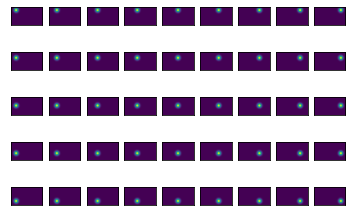

In [21]:
# TODO: prettify the plots
f, ax = plt.subplots(n_channels[1], n_channels[0])
i = 0
for ii in range(n_channels[1]):
    for jj in range(n_channels[0]):
        ax[ii, jj].imshow(basis_fcns[i, :].reshape(stim_res[1], 
                                                   stim_res[0]))
        ax[ii, jj].axes.get_xaxis().set_visible(False)
        ax[ii, jj].axes.get_yaxis().set_visible(False)
        i += 1
plt.show()

In [12]:
# TODO: show summed together basis functions
# TODO: show cross-section of summed basis functions to demonstrate they are flat/smooth

In [47]:
# nobs = 100
# sx = np.linspace(-6, 6, 10) #np.random.randint(0, high=12, size=(nobs, 1)) - 6
# sy = np.linspace(-3, 3, 10) #np.random.randint(0, high=6, size=(nobs, 1)) - 3
# sxx, syy = np.meshgrid(sx, sy)
# ydata = np.hstack((sxx.reshape(-1, 1), syy.reshape(-1, 1)))

C = iem_obj._define_trial_activations(trn_conds)
print(C.shape)

(128, 45)


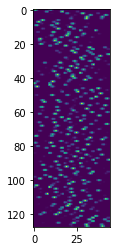

In [48]:
plt.imshow(C)

In [49]:
# nvox = 1000
# X = np.zeros((nobs, nvox))
# for i, l in enumerate(np.linspace(-1, 1, 10)):
#     X[i*10:i*10+10, :] = np.random.normal(loc=l, scale=1.5, 
#                                     size=(10, nvox))
iem_obj = iem_obj.fit(trn, trn_conds)

print(iem_obj.W_.shape)

(653, 45)


In [50]:
stim_reconstructions = iem_obj.predict_feature_responses(tst)
print(stim_reconstructions.shape)

(17271, 288)


In [51]:
vmin, vmax = 0, 0
mean_recons = np.zeros((stim_contrasts.size, attn_conds.size, npixels))

for aa, attn_cond in enumerate(attn_conds):
    for ss, contrast in enumerate(stim_contrasts):
        thisidx = np.argwhere((tst_conds[:, 0] == 1) &
                              (tst_conds[:, 1] == contrast) &
                              (tst_conds[:, 2] == attn_cond) &
                              (tst_conds[:, 3] == 0))
        rs = np.mean(stim_reconstructions[:, thisidx], axis=1)
        if rs.min() < vmin:
            vmin = rs.min()
        if rs.max() > vmax:
            vmax = rs.max()
        mean_recons[ss, aa, :] = rs.squeeze()

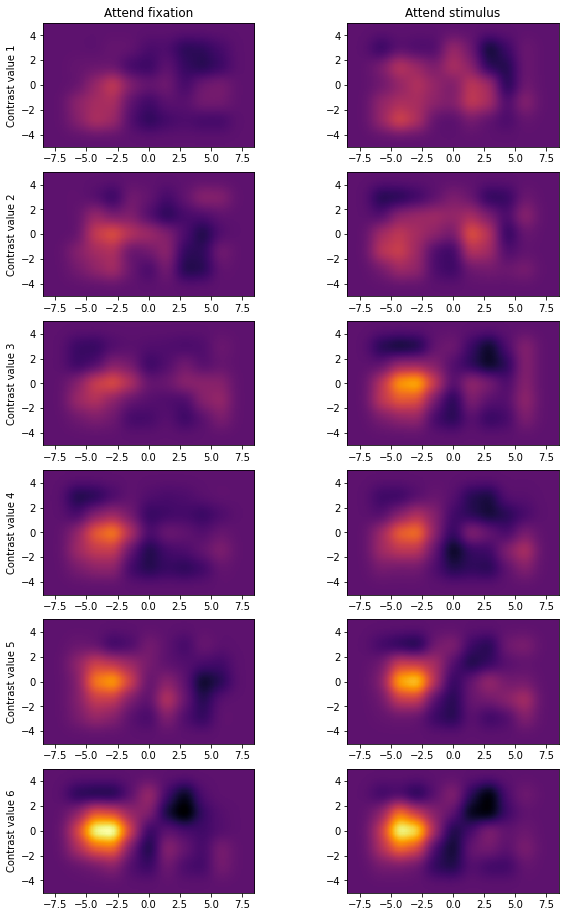

In [52]:
f, ax = plt.subplots(6, 2, figsize=(10,16))
for aa, attn_cond in enumerate(attn_conds):
    for ss, contrast in enumerate(stim_contrasts):
        ax[ss, aa].imshow(mean_recons[ss, aa, :].\
                          reshape(stim_res[1], stim_res[0]),
                          origin='lower', interpolation='none',
                          cmap='inferno',
                          extent=[stimx[0], stimx[1], stimy[0], stimy[1]],
                          vmin=vmin, vmax=vmax)
        if contrast == stim_contrasts[0]:
            if attn_cond == 1:
                ax[ss, aa].set_title('Attend fixation')
            elif attn_cond == 2:
                ax[ss, aa].set_title('Attend stimulus')
        if attn_cond == 1:
            ax[ss, aa].set_ylabel('Contrast value {}'.format(contrast))

In [19]:
# X2 = np.zeros((5, nvox))
# for i, l in enumerate(np.linspace(-1, 1, 5)):
#     X2[i, :] = np.random.normal(loc=l, scale=1.5, 
#                                     size=(1, nvox))
# pred_vals = iem_obj.predict()
# print(pred_vals, pred_vals.shape)